![logo_ironhack_blue 7](https://user-images.githubusercontent.com/23629340/40541063-a07a0a8a-601a-11e8-91b5-2f13e4e6b441.png)

# Lab | Making predictions with logistic regression

In this lab, you will be using the Sakila database of movie rentals.
In order to optimize our inventory, we would like to know which films will be rented. 
We are asked to create a model to predict it. So we use the information we have from May 2005 to create the model.

# Importing Libraries

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

 ········


# Instructions

## Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X).

In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/Sakila'
engine = create_engine(connection_string)

In [3]:
# Define the SQL query
sql_query = '''
SELECT
    f.film_id,
    f.title,
    f.release_year,
    f.language_id,
    f.rental_duration,
    f.rental_rate,
    f.length,
    f.rating,
    f.special_features,
    fc.category_id
FROM
    film f
LEFT JOIN
    inventory i ON f.film_id = i.film_id
LEFT JOIN
    rental r ON i.inventory_id = r.inventory_id
LEFT JOIN
    film_category fc ON f.film_id = fc.film_id;
'''

# Execute the query and read the data into a DataFrame
film_features= pd.read_sql_query(sql_query, engine)

# Display the DataFrame
film_features

,film_id,title,release_year,language_id,rental_duration,rental_rate,length,rating,special_features,category_id
0,1,ACADEMY DINOSAUR,2006,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",6
1,1,ACADEMY DINOSAUR,2006,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",6
2,1,ACADEMY DINOSAUR,2006,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",6
3,1,ACADEMY DINOSAUR,2006,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",6
4,1,ACADEMY DINOSAUR,2006,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",6
...,...,...,...,...,...,...,...,...,...,...
16082,1000,ZORRO ARK,2006,1,3,4.99,50,NC-17,"Trailers,Commentaries,Behind the Scenes",5
16083,1000,ZORRO ARK,2006,1,3,4.99,50,NC-17,"Trailers,Commentaries,Behind the Scenes",5
16084,1000,ZORRO ARK,2006,1,3,4.99,50,NC-17,"Trailers,Commentaries,Behind the Scenes",5
16085,1000,ZORRO ARK,2006,1,3,4.99,50,NC-17,"Trailers,Commentaries,Behind the Scenes",5


## Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.

In [4]:
# Define the SQL query
sql_query = '''
SELECT
    f.title,
    f.release_year,
    f.language_id,
    f.rental_duration,
    f.rental_rate,
    f.length,
    f.rating,
    f.special_features,
    fc.category_id,
    MAX(CASE
        WHEN r.rental_date BETWEEN '2005-05-01' AND '2005-05-31' THEN 1
        ELSE 0
    END) AS rented_in_may
FROM
    film f
LEFT JOIN
    inventory i ON f.film_id = i.film_id
LEFT JOIN
    rental r ON i.inventory_id = r.inventory_id
LEFT JOIN
    film_category fc ON f.film_id = fc.film_id
GROUP BY
    f.title,
    f.release_year,
    f.language_id,
    f.rental_duration,
    f.rental_rate,
    f.length,
    f.rating,
    f.special_features,
    fc.category_id;
'''

# Execute the query and read the data into a DataFrame
films_rented_in_may = pd.read_sql_query(sql_query, engine)

## Read the data into a Pandas dataframe. At this point you should have 1000 rows. Number of columns depends on the number of features you chose.

In [5]:
films_rented_in_may

,title,release_year,language_id,rental_duration,rental_rate,length,rating,special_features,category_id,rented_in_may
0,ACADEMY DINOSAUR,2006,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",6,1
1,ACE GOLDFINGER,2006,1,3,4.99,48,G,"Trailers,Deleted Scenes",11,0
2,ADAPTATION HOLES,2006,1,7,2.99,50,NC-17,"Trailers,Deleted Scenes",6,0
3,AFFAIR PREJUDICE,2006,1,5,2.99,117,G,"Commentaries,Behind the Scenes",11,1
4,AFRICAN EGG,2006,1,6,2.99,130,G,Deleted Scenes,8,1
...,...,...,...,...,...,...,...,...,...,...
995,YOUNG LANGUAGE,2006,1,6,0.99,183,G,"Trailers,Behind the Scenes",6,0
996,YOUTH KICK,2006,1,4,0.99,179,NC-17,"Trailers,Behind the Scenes",12,0
997,ZHIVAGO CORE,2006,1,6,0.99,105,NC-17,Deleted Scenes,11,1
998,ZOOLANDER FICTION,2006,1,5,2.99,101,R,"Trailers,Deleted Scenes",3,1


## Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [6]:
# Assuming film_may_features is the DataFrame containing the extracted features
y = films_rented_in_may['rented_in_may']

# Drop title, and rented_in_may from X
X = films_rented_in_may.drop(columns=['title', 'rented_in_may'])

# Encode categorical variables using one-hot encoding
categorical_columns = ['rating', 'special_features']
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_categorical = encoder.fit_transform(X[categorical_columns])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_columns))
X = pd.concat([X, encoded_categorical_df], axis=1)

# Drop the original categorical columns from X
X.drop(columns=categorical_columns, inplace=True)

# Scale numerical variables using StandardScaler
numerical_columns = ['release_year', 'language_id', 'rental_duration', 'rental_rate', 'length']
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(X[numerical_columns])
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_columns)
X = pd.concat([X, scaled_numerical_df], axis=1)

# Drop the original numerical columns from X
X.drop(columns=numerical_columns, inplace=True)

C:\Users\duart\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Create a logistic regression model to predict 'rented_in_may' from the cleaned data.

Confusion Matrix:
[[  9 151]
 [ 12 228]]


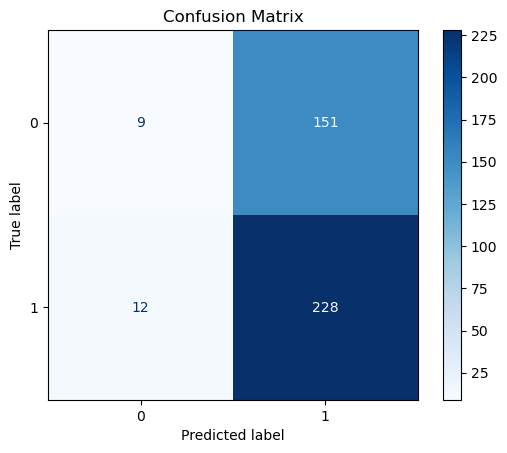

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=24)

# Create a logistic regression model
logreg_model = LogisticRegression()

# Fit the model to the training data
logreg_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logreg_model.predict(X_test)

# Evaluate the model
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=logreg_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


## Evaluate the results.